In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
import FiniteDiff
import ForwardDiff as FD
import Convex as cvx 
import ECOS
using LinearAlgebra
using Plots
using Random
using JLD2
using Test
using MeshCat
const mc = MeshCat
using StaticArrays
using Printf

import MathOptInterface as MOI
import Ipopt 
using Statistics 

  Activating environment at `C:\Users\shara\OCRL_Project\Project.toml`


In [2]:
include(joinpath(@__DIR__, "utils","mpc_visualizer.jl"))
include(joinpath(@__DIR__, "utils","fmincon.jl"))

fmincon (generic function with 1 method)

In [3]:
function car_dynamics(x::Vector, u::Vector)::Vector
    # nonlinear bicycle model continuous time dynamics 
    px, py, θ, δ, v = x 
    a, δdot = u 
    L = 2.8
    lr = 1.6
    
    β = atan(lr * δ, L)
    s,c = sincos(θ + β)
    sb=sin(β)
    ω = v*cos(β)*tan(δ) / L
    
    vx = v*c 
    vy = v*s 
    vs=v*sb/lr
   
    

    xdot = [
        vx,
        vy,
        ω,
        δdot, 
        a
    ]
end
function rk4( ode::Function, x, u, dt::Real)
    k1 = dt * ode(x, u)
    k2 = dt * ode( x + k1/2, u)
    k3 = dt * ode( x + k2/2, u)
    k4 = dt * ode( x + k3,   u)
    return x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end   


rk4 (generic function with 1 method)

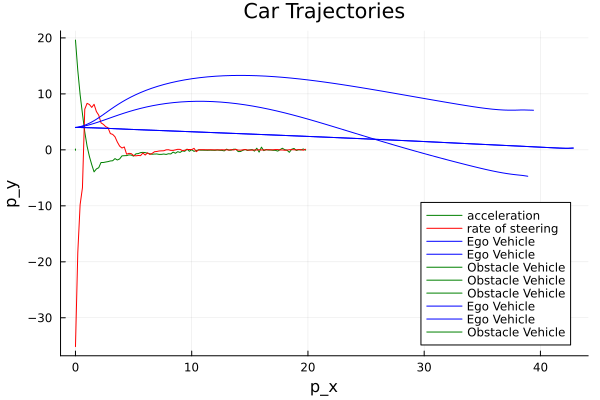

[[0.0, 0.0, 0.0, 0.0, 0.0]; [0.004000000000000001, 0.0, 0.0, 0.0, 0.04000000000000001]; [0.0159992, 0.0, 0.0, 0.0, 0.07999200000000001]; [0.03599440016, 0.0, 0.0, 0.0, 0.1199600016]; [0.063979201599968, 0.0, 0.0, 0.0, 0.15988801279968]; [0.09994400831958401, 0.0, 0.0, 0.0, 0.1997600543964801]; [0.1438760303972161, 0.0, 0.0, 0.0, 0.23956016637984093]; [0.19575928846710483, 0.0, 0.0, 0.0, 0.2792724143190465]; [0.2555746194732207, 0.0, 0.0, 0.0, 0.31888089574211226]; [0.32329968369774853, 0.0, 0.0, 0.0, 0.35836974650316583]; [0.39890897306164214, 0.0, 0.0, 0.0, 0.39772314713577034]; [0.4823738206941839, 0.0, 0.0, 0.0, 0.43692532918964705]; [0.5736624117679745, 0.0, 0.0, 0.0, 0.4759605815482587]; [0.6727397955952726, 0.0, 0.0, 0.0, 0.5148132567247228]; [0.7795678989810981, 0.0, 0.0, 0.0, 0.5534677771335322]; [0.8941055408280083, 0.0, 0.0, 0.0, 0.5919086413355701]; [1.0163084479869569, 0.0, 0.0, 0.0, 0.6301204302539141]; [1.1461292723481422, 0.0, 0.0, 0.0, 0.6680878133579402]; [1.2835176091

In [21]:

function controller(N)
    dt = 0.2 
    K = 0.01 # mpc
    x_ic=[0,0,0,0,0]
    x_goal=[20,0,0,0,0]
    X=[zeros(5) for i = 1:N]
    X[1]=x_ic
    for k in 1:N-1 
        u = -K * (X[k] - x_goal)
        X[k+1] = rk4(car_dynamics, X[k], u, dt)
        
    end
    return X
end

dt = 0.2
tf = 30.0 
t_vec = 0:dt:tf 
N = length(t_vec)
X2=controller(N)
display(plot!(X2[1,:], X2[2,:], color = :green, label = "Obstacle Vehicle", xlabel = "p_x", ylabel = "p_y"))
# print(X2[:,:])
# print(N)



In [18]:
function vec_from_mat(Xm::Matrix)::Vector{Vector{Float64}}
    # convert a matrix into a vector of vectors 
    X = [Xm[:,i] for i = 1:size(Xm,2)]
    return X 
end
#use this function for mpc 
function mpc_update(X_ref, 
                    xic::Vector{Float64},
                    As::Vector{Matrix{Float64}},  
                    Bs::Vector{Matrix{Float64}},  
                    Q::Matrix,                    
                    R::Matrix,                   
                    Qf::Matrix                     
                    )::Vector{Vector{Float64}}     
    # N = length(Xsim)
    nx,nu = size(Bs[1])
    N = 20
    X = cvx.Variable(nx, N)
    U = cvx.Variable(nu, N-1)

    # xic=[0,5,0,0,0]
    u_max=ones(2)
    u_min=-u_max
    
    X2=hcat(X_ref...)

    xg= [44, 1, 0, 0, 0]
    cost = 0.0
    for k = 1:(N-1)
        x_k = X[:,k]
        u_k = U[:,k]
        # xgg=[Xr[k],Yr[k],0,0]
        xgg=X2[:,k]

        
        cost += 0.5*(cvx.quadform(x_k - xgg, Q)) + 0.5*(cvx.quadform(u_k, R))
    end
    
    # terminal cost
    x_n = X[:,end]
    cost += (cvx.quadform(x_n - xg, Qf))
    
    # problem instance 
    prob = cvx.minimize(cost)

    # TODO: initial condition constraint
    prob.constraints += (X[:,1] == xic)
    prob.constraints += (X[:,N] == xg)
    
    
    for k = 1:N-1
        x3= X[3,k]
        x4=X[4,k]
        
        prob.constraints += x3 >= 0
        prob.constraints += x3 <= 10
        prob.constraints += x4 >= 0
        prob.constraints += x4 <= 10
        
        
        
    end
    
    for k = 1:N
        xi1 = X[:,k][1:2]
        lat_val = X[:,k][2]
        
        xi2 = [X2[1,k],X2[2,k]]
        # vel= X2[5,k]
        prob.constraints += norm(xi1-xi2) >=6 #obstacle avoidance
        
        prob.constraints += lat_val>=-2.5 #lane constraint
    
    end
    for k=1:N-5
        lat_val = X[:,k][2]
        prob.constraints += lat_val<=8 #lane constraint
    end
    for k=1:N-1
        vel_ego = X[:,k][5]
        vel_obs= X2[5,k]
        prob.constraints += vel_ego > vel_obs #velocity constraint
        prob.constraints += vel_ego < 2*vel_obs #velocity constraint
    end
    for k=1:N-1
        prob.constraints += U[:,k] >= u_min
        prob.constraints += U[:,k] <= u_max
        
    end
    
    

    #dynamics constraints
    for k = 1:(N-1)
        prob.constraints += (X[:,k+1] == As[k]*X[:,k] + Bs[k]*U[:,k])
    end

    cvx.solve!(prob, ECOS.Optimizer; silent_solver = true)

    # return ΔU 
    x=X.value
    u=U.value
    X = vec_from_mat(x)
    U = vec_from_mat(u)

    return U
end


cvx_update (generic function with 1 method)

In [11]:
function finetune(xi, xg, u)
    # if norm(xi - xg) < 1
    #     # assume no thruster errors within 1 m 
    #     return u 
    # # elseif  norm(xi - xg) > 6
    # #     u[1]=u[1]
    # #     u[2]=0.8*u[2]
    # #     return u
    # elseif xi[2]>5
    #     # u[2]=0.7*u[2]
    #     # u[1]=1.1*u[1]
    #     return u
    # # elseif  norm(xi - xg) < 5
    # #     u[1]=u[1]
    # #     u[2]=u[2]
    # #     return u
    # else
    #     u[1]=u1.1*[1]
        return u
    # end
end

finetune (generic function with 1 method)

In [12]:
function control_adjust(xi, xg, u)
    # Assume adjustments for control inputs based on system-specific factors
    if norm(xi[1:2] - xg[1:2]) < 1  # Check proximity in x, y
        return u  # No adjustment if close to the goal
    else
        # Apply any required control adjustments
        control_factor = Diagonal([0.9,0.9])  # Placeholder for control scali
        # Apply the scaling factor to each control vector
        scaled_u = control_factor *u
        return scaled_u 

    end
end
function state_estimate(xi, xg)
    if norm(xi - xg) < 1 
        return xi 
    else
        position_σ = .1 #  m 
        theta_σ=0.01
        velocity_σ = .001 # m/s
        return xi + [position_σ*randn(1);position_σ*randn(1) ; theta_σ*randn(1); theta_σ*randn(1);velocity_σ*randn(1)]
    end
end

state_estimate (generic function with 1 method)

In [ ]:
@testset "MPC" begin 
    
    # problem size 
    nx = 5
    nu = 2
    dt = 0.2
    tf = 30.0 
    t_vec = 0:dt:tf 
    N = length(t_vec)
    
    N_mpc=20
  
    X_sim = [zeros(nx) for i = 1:N]

    U_sim = [zeros(nu) for i = 1:N-1]
    
    
    # initial and terminal conditions 
    xic=[0,4,0,0,0]
    # xg=[26,0,0,0,0]
    xg= [43, 2.2, 0, 0, 0]
    x2ic=[0,0,0,0,0]
    x2g=[20,0,0,0,0]
    
    X2=controller(N)
    Q = diagm([5,5,200,200,100])
    R = 10*diagm(ones(nu))
    Qf = 1*diagm(ones(nx))
    
    Xsim = [zeros(nx) for i = 1:N]
    X_sim[1] = xic
    
    As = [zeros(nx,nx) for i = 1:N]
    Bs = [zeros(nu,nx) for i = 1:N-1]

    ug=[0,0]

    #lanes
    l1_1=[zeros(5) for i = 1:N]
    l1_2=[zeros(5) for i = 1:N]
    l2_1=[zeros(5) for i = 1:N]

    for i in 1:N
        l1_1[i]=[i-5,-2.5,0,0,0]
        l1_2[i]=[i-5,2.5,0,0,0]
        l2_1[i]=[i-5,7.5,0,0,0]
    end
    
    
            
    for i = 1:(N-1)
        xgg=X2[i]
        
        As[i] = FD.jacobian(x -> rk4(car_dynamics, x, ug, dt), xgg)
        Bs[i] = FD.jacobian(u -> rk4(car_dynamics, xgg, u, dt), ug)
    end 
    
    for i = 1:130-1 
        xi_estimate = state_estimate(X_sim[i], xg)
        u_mpc = mpc_update(X2[i:i+N_mpc-1, :], xi_estimate, As[i:i+N_mpc-1], Bs[i:i+N_mpc-1], Q, R, Qf)
        u_n=u_mpc[1]
        U_sim[i] = control_adjust(X_sim[i], xg, u_n)
        X_sim[i+1] = As[i]*X_sim[i] + Bs[i]*U_sim[i]
    end
        
    t_vec_contr = t_vec[1:end-51] 
    u1_mpc = [U_sim[i][1] for i in 1:length(U_sim)-50]
    u2_mpc = [U_sim[i][2] for i in 1:length(U_sim)-50]
    
    
   # --------plotting/animation-------
    Xm= hcat(X_sim...)
    X2m=hcat(X2...)

    
    
    # animation
    vis = Visualizer()
    vis_traj!(vis, :traj1, [[x[1],x[2],0.1] for x in l1_1]; R = 0.02)
    vis_traj!(vis, :traj2, [[x[1],x[2],0.1] for x in l1_2]; R = 0.02)
    vis_traj!(vis, :traj3, [[x[1],x[2],0.1] for x in l2_1]; R = 0.02)
    

    
    build_car2!(vis[:car])
    build_car!(vis[:car2])
    anim = mc.Animation(floor(Int,1/dt))
    for k = 1:N-50
        mc.atframe(anim, k) do
            update_car_pose!(vis[:car2], X_sim[k])
        end
    end
    for k = 1:N-1
        mc.atframe(anim, k) do
            update_car_pose!(vis[:car], X2[k])
        end
    end
    mc.setanimation!(vis, anim)
    display(render(vis))

    
    display(plot(X2m[1,:], X2m[2,:], color = :green, xlabel="X", ylabel="Y",title = "Car Trajectories", label = "Obstacle Vehicle"))
    display(plot!(Xm[1,1:N-50], Xm[2,1:N-50], color = :blue,xlabel="X", ylabel="Y",title = "Car Trajectories", label = "Ego Vehicle"))
    plot(t_vec_contr, u1_mpc,color=:green, label="acceleration", xlabel="Time (s)", ylabel="Control Variables", title="Control Variables Over Time")
    display(plot!(t_vec_contr, u2_mpc, color=:red,label="rate of steering"))

    
    
    
        
end

┌ Warning: Expression not DCP compliant. Trying to solve non-DCP compliant problems can lead to unexpected behavior.
└ @ Convex C:\Users\shara\.julia\packages\Convex\b2S4H\src\dcp.jl:25
┌ Warning: Problem not DCP compliant: constraint 79 is not DCP
└ @ Convex C:\Users\shara\.julia\packages\Convex\b2S4H\src\problems.jl:60
┌ Warning: Expression not DCP compliant. Trying to solve non-DCP compliant problems can lead to unexpected behavior.
└ @ Convex C:\Users\shara\.julia\packages\Convex\b2S4H\src\dcp.jl:25
┌ Warning: Problem not DCP compliant: constraint 81 is not DCP
└ @ Convex C:\Users\shara\.julia\packages\Convex\b2S4H\src\problems.jl:60
┌ Warning: Expression not DCP compliant. Trying to solve non-DCP compliant problems can lead to unexpected behavior.
└ @ Convex C:\Users\shara\.julia\packages\Convex\b2S4H\src\dcp.jl:25
┌ Warning: Problem not DCP compliant: constraint 83 is not DCP
└ @ Convex C:\Users\shara\.julia\packages\Convex\b2S4H\src\problems.jl:60
┌ Warning: Expression not DCP c